In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
df1 = pd.read_csv("Resources/hawaii_measurements.csv")
df1[df1["date"]>"2016-08-23"].max()



station    USC00519523
date        2017-08-23
prcp               6.7
tobs                87
dtype: object

# Exploratory Precipitation Analysis

In [10]:
#find out last date
session.query(func.max(Measurement.date)).all()

[('2017-08-23')]

In [37]:
#Filter Prcp measurements for last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >'2016-08-23' ).all()

#Load results into pandas dataframe
df = pd.DataFrame(results, columns=['Date','Precipitation'])
df.set_index('Date', inplace=True)
df=df.sort_values("Date")
df.max()


Precipitation    6.7
dtype: float64

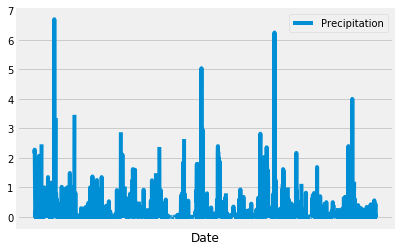

In [39]:
# Plot the dataframe as a bar chart using pandas plotting
df.plot()
plt.xticks([])
plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df.describe())

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.name)).all()
total_stations

[(9)]

In [54]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
active_station



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()
temp

[(54.0, 85.0, 71.66378066378067)]

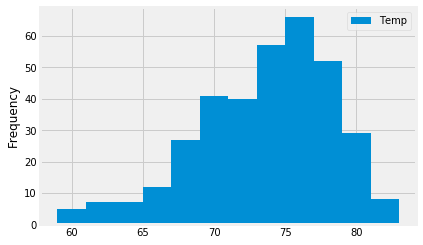

In [50]:
temp_data = session.query(Measurement.tobs).\
           filter(Measurement.date >'2016-08-23').\
           filter(Measurement.station =="USC00519281").all()

df2 = pd.DataFrame(temp_data, columns=["Temp"])
df2.plot.hist(bins=12)
plt.show()


In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2013-01-28', '2014-02-21'))

[(53.0, 72.44735006973501, 86.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.i.e. 2016-04-23 to 2016-04-29
print(calc_temps('2016-04-23', '2016-04-29'))

[(68.0, 75.6304347826087, 79.0)]


[(68.0, 75.6304347826087, 79.0)]


C:\Users\amathur1\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


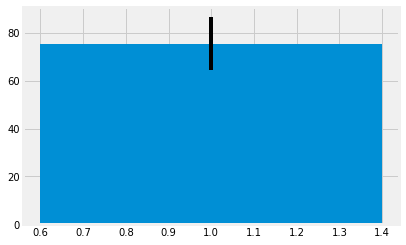

In [59]:
last_yr_temp = calc_temps('2016-04-23', '2016-04-29')
print(last_yr_temp)

fig, ax = plt.subplots()

x=1
yerr = last_yr_temp[0][2] - last_yr_temp[0][0]
y = last_yr_temp[0][1]
rects1 = ax.bar(x, y, yerr=yerr)
fig.show()

In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#how do you join in sqlalchemy ?

def calc_prcp(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.min(Measurement.prcp), func.avg(Measurement.prcp), func.max(Measurement.prcp)).\
               filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.station).order_by(func.max(Measurement.prcp).desc()).all()

# Prcp during trip dates last year 
print(calc_prcp('2016-04-23', '2016-04-29'))

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0, 0.0955, 0.99), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0, 0.0955, 0.99), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0, 0.0955, 0.99), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0, 0.0955, 0.99), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0, 0.0955, 0.99), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0, 0.0955, 0.99), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0, 0.0955, 0.99), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, 0.0955, 0.99), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0, 0.0955, 0.99)]


In [ ]:
# Build a FLASK
@app.route("/api/v1.0/temp/<start>/<end>")
def stats(start=None, end=None):
